In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision

from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:

# device configuration
print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

Using PyTorch version: 2.8.0+cu126
Using GPU, device name: Tesla T4


In [3]:
import torchvision
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)




100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 502kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.60MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.84MB/s]


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2) # maxpool layer
        self.fc1 = nn.Linear(32 * 14 * 14, 128) ## fully onnected layer with 128 neurons
        self.fc2 = nn.Linear(128, 10) ##output lyer with 10 neurons

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cnn_model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

In [5]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    train_loss_history = []
    train_accuracy_history = []

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Compute epoch stats
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        train_loss_history.append(epoch_loss)
        train_accuracy_history.append(epoch_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_acc:.2f}%")



    return model, train_loss_history, train_accuracy_history


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
cnn_model, train_loss, train_accuracy = train_model(
    cnn_model, train_loader, criterion, optimizer, num_epochs=10, device=device)

Epoch [1/10] | Train Loss: 0.2702 | Train Accuracy: 92.25%
Epoch [2/10] | Train Loss: 0.0796 | Train Accuracy: 97.67%
Epoch [3/10] | Train Loss: 0.0573 | Train Accuracy: 98.23%
Epoch [4/10] | Train Loss: 0.0453 | Train Accuracy: 98.61%
Epoch [5/10] | Train Loss: 0.0339 | Train Accuracy: 98.95%
Epoch [6/10] | Train Loss: 0.0279 | Train Accuracy: 99.15%
Epoch [7/10] | Train Loss: 0.0228 | Train Accuracy: 99.28%
Epoch [8/10] | Train Loss: 0.0177 | Train Accuracy: 99.45%
Epoch [9/10] | Train Loss: 0.0141 | Train Accuracy: 99.57%
Epoch [10/10] | Train Loss: 0.0120 | Train Accuracy: 99.61%


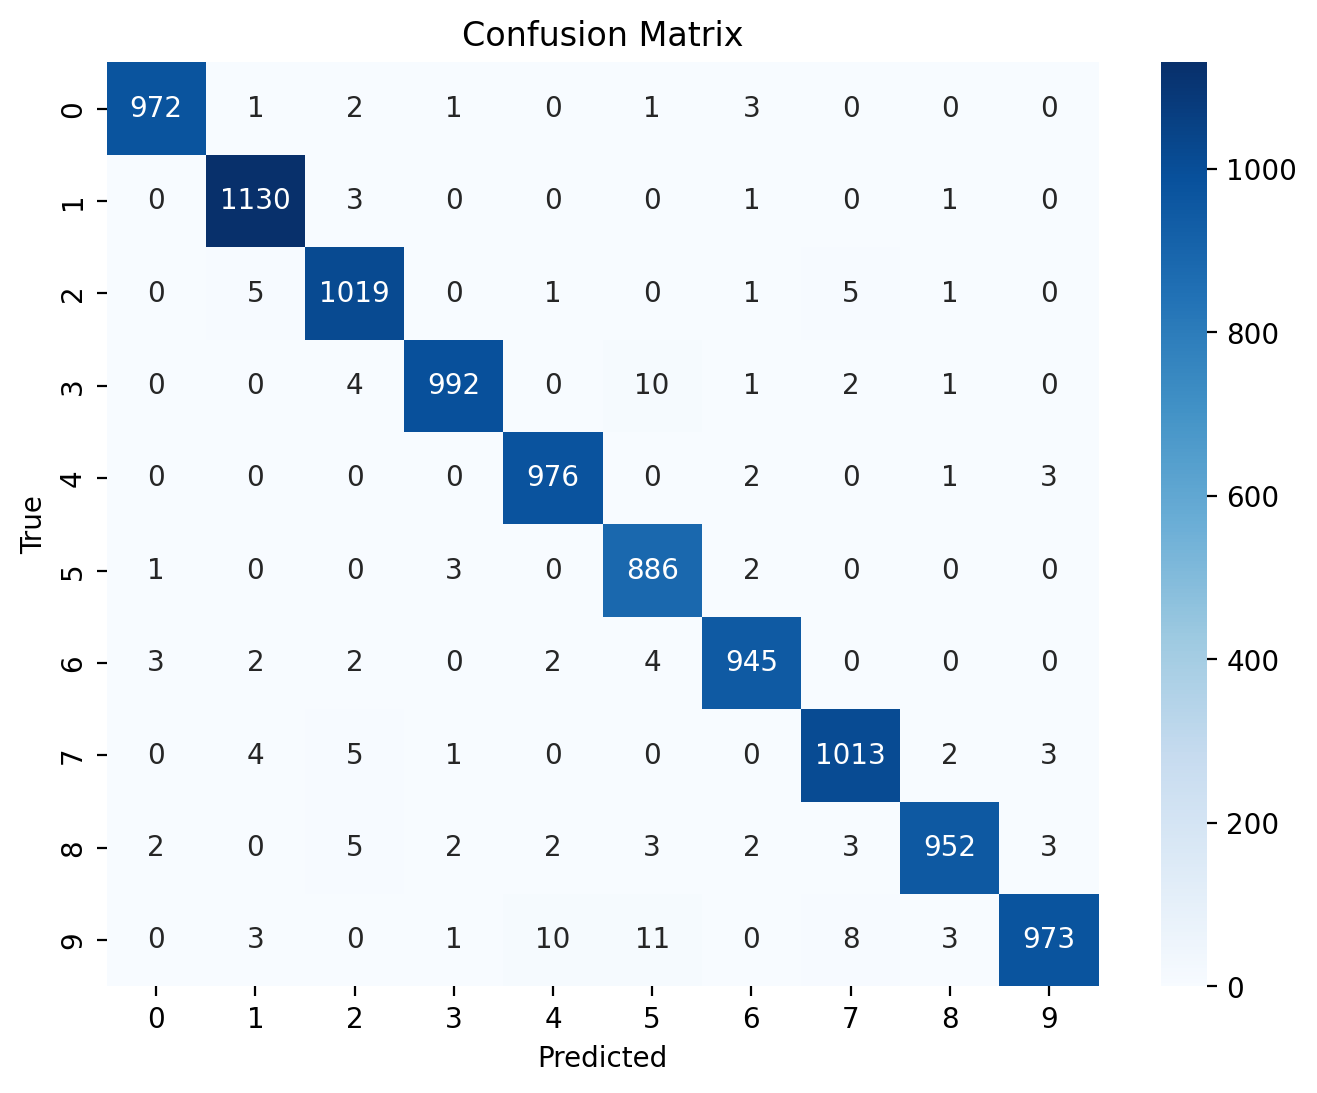

Accuracy       : 98.58%
F1-score (macro): 0.9857
Number of Parameters: 804,554
Inference Time on Test Set: 2.4714 seconds


In [7]:
import time
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score

def evaluate_model(model, test_loader, device='cpu'):
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    start_time = time.time()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)


            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    end_time = time.time()
    inference_time = end_time - start_time

    # Compute metrics
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)

    # plot the confusion_matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[str(i) for i in range(10)],
                yticklabels=[str(i) for i in range(10)])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Model size (number of parameters)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Print results

    print(f"Accuracy       : {acc*100:.2f}%")
    print(f"F1-score (macro): {f1:.4f}")
    print(f"Number of Parameters: {total_params:,}")
    print(f"Inference Time on Test Set: {inference_time:.4f} seconds")



    return acc, f1, total_params, inference_time

cnn_acc, cnn_f1, cnn_params, cnn_inference_time = evaluate_model(cnn_model, test_loader, device=device)


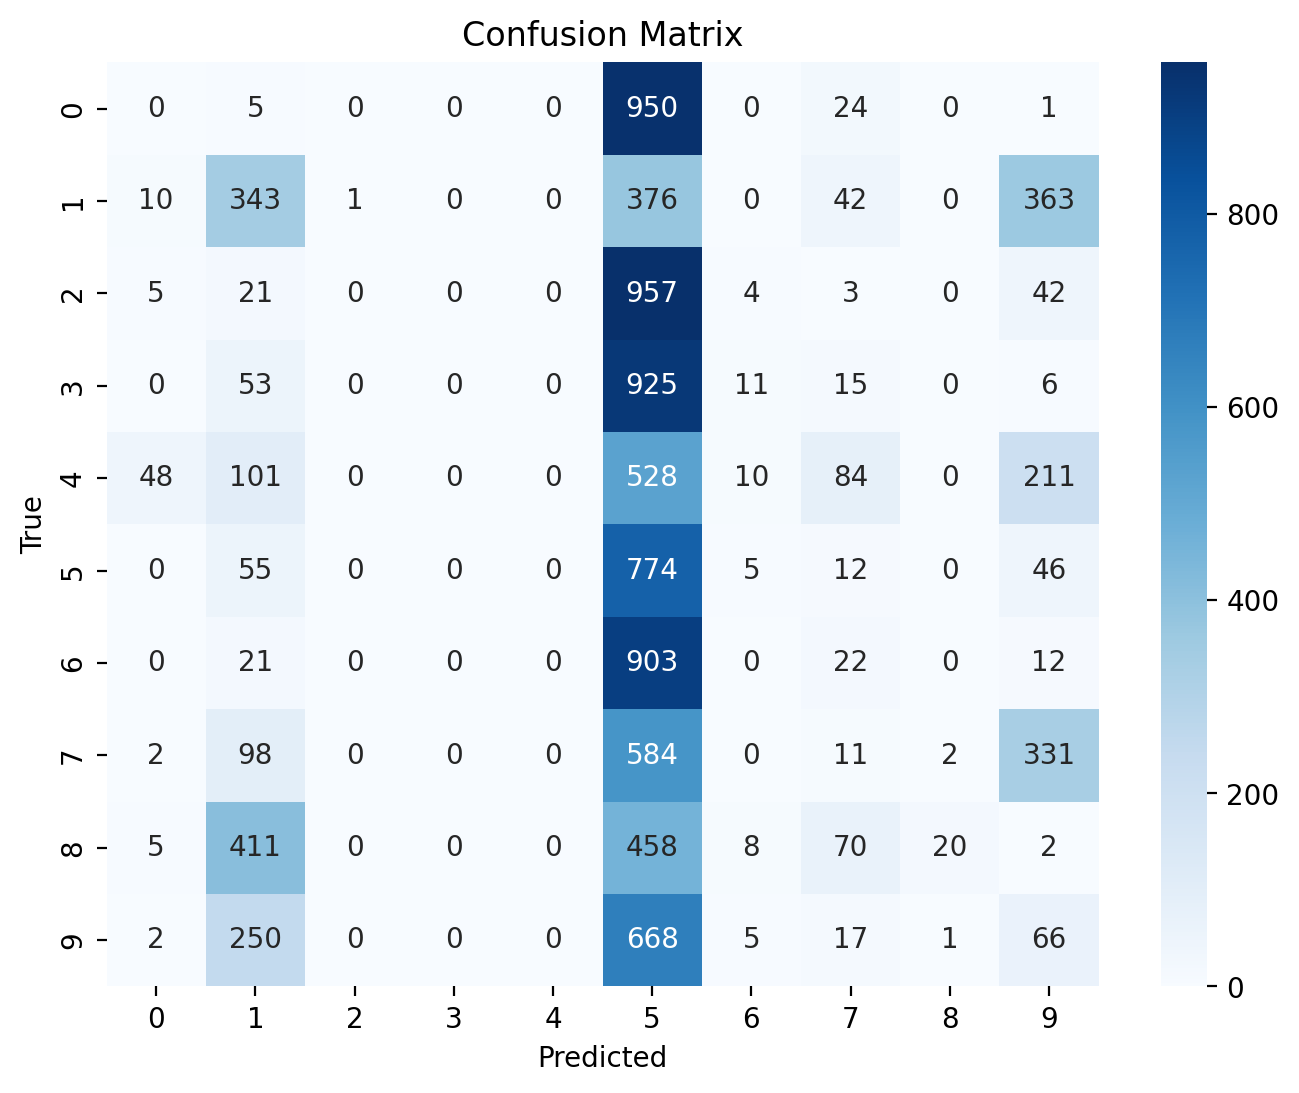

Accuracy       : 12.14%
F1-score (macro): 0.0588
Number of Parameters: 2,236,682
Inference Time on Test Set: 27.1525 seconds


In [23]:
model_mobilenet = models.mobilenet_v2(weights='IMAGENET1K_V1')  # pretrained weights
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.last_channel, 10)  # 10 output classes (digits 0–9)

model_mobilenet.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mobilenet = model_mobilenet.to(device)

pretrained_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_pretrained = torchvision.datasets.MNIST(root='./data', train=False, transform=pretrained_transform)
test_loader_pretrained = DataLoader(test_pretrained, batch_size=64, shuffle=False)


acc_pretrained_mobilenet, f1_pretrained_mobilenet, params_pretrained_mobilenet, inference_time_pretrained_mobilenet = evaluate_model(model_mobilenet, test_loader_pretrained, device=device)



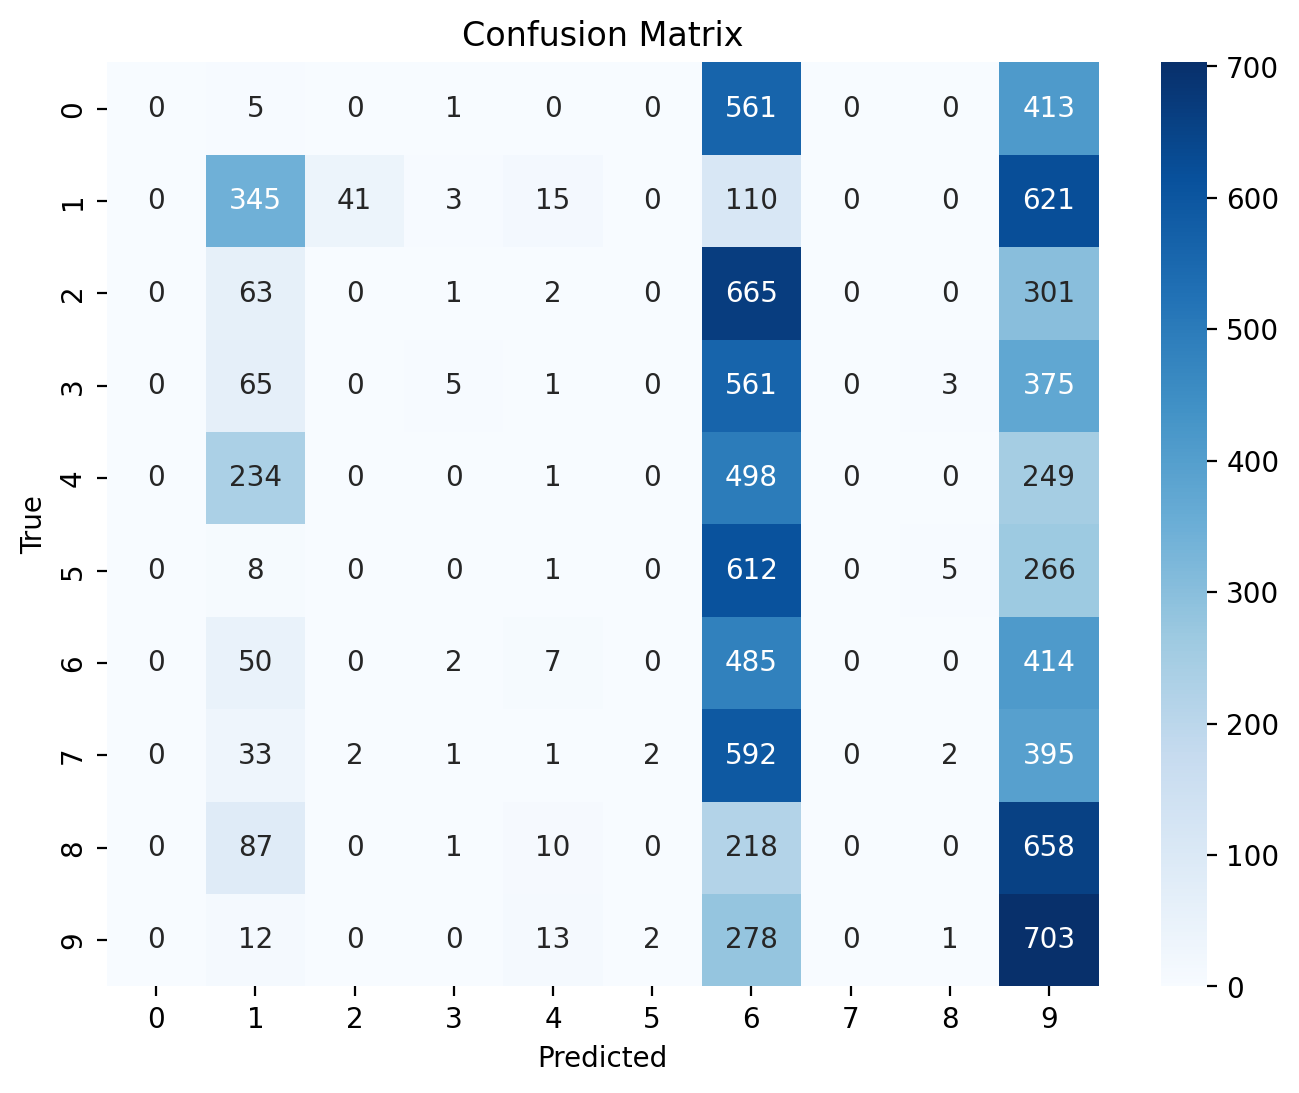

Accuracy       : 15.39%
F1-score (macro): 0.0786
Number of Parameters: 4,020,358
Inference Time on Test Set: 30.0072 seconds


In [24]:

model_efficientnet = models.efficientnet_b0(weights='IMAGENET1K_V1')
model_efficientnet.classifier[1] = nn.Linear(1280, 10)
model_efficientnet.eval()
model_efficientnet = model_efficientnet.to(device)

pretrained_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_pretrained = torchvision.datasets.MNIST(root='./data', train=False, transform=pretrained_transform)
test_loader_pretrained = DataLoader(test_pretrained, batch_size=64, shuffle=False)

acc_pretrained_efficientnet, f1_pretrained_efficientnet, params_pretrained_efficientnet, inference_time_pretrained_efficientnet = evaluate_model(model_efficientnet, test_loader_pretrained, device=device)



In [ ]:



data = {
    "Model": ["CNN (Custom)", "MobileNetV2 (Pretrained)", "EfficientNetB0 (Pretrained)"],
    "Accuracy": [cnn_acc, acc_pretrained_mobilenet, acc_pretrained_efficientnet],
    "F1-Score": [cnn_f1, f1_pretrained_mobilenet, f1_pretrained_efficientnet],
    "Parameters": [cnn_params, params_pretrained_mobilenet, params_pretrained_efficientnet],
    "Inference Time (s)": [cnn_inference_time, inference_time_pretrained_mobilenet, inference_time_pretrained_efficientnet]
}
df_comparison = pd.DataFrame(data)

df_comparison

,Model,Accuracy,F1-Score,Parameters,Inference Time (s)
0,CNN (Custom),98.58,0.9857,804554,2.4714
1,MobileNetV2 (Pretrained),12.14,0.0588,2236682,27.1525
2,EfficientNetB0 (Pretrained),15.39,0.0786,404020358,30.0072


The custom CNN achieved the best performance with an accuracy of 98.58% and an F1-score of 0.9857, confirming that it effectively learned the features of handwritten digits. The model’s relatively small parameter count and architecture specifically designed for the MNIST dataset led to both high accuracy and low inference time (2.47 s).

In contrast, both MobileNetV2 and EfficientNetB0, which were pretrained on the ImageNet dataset, performed poorly on MNIST, achieving accuracies of only 12.14% and 15.39%, respectively. This significant drop in performance is expected, as these models were trained on RGB natural images (224×224) containing objects like animals and vehicles, which differ drastically from the grayscale handwritten digits (28×28) in MNIST.

Additionally, due to their deeper architectures and higher parameter counts, both pretrained models exhibited longer inference times (~27–30 s) compared to the lightweight CNN. This highlights the computational inefficiency of applying large-scale pretrained models to simpler tasks without adaptation.

Overall, the results clearly demonstrate that dataset-specific training is critical for achieving high performance.

### Fine-tuning the pretrained Mobile_net model on the MNIST dataset

In [18]:
model_mobilenet_train = models.mobilenet_v2(weights='IMAGENET1K_V1')  # pretrained weights
model_mobilenet_train.classifier[1] = nn.Linear(model_mobilenet_train.last_channel, 10)  # 10 output classes (digits 0–9)
model_mobilenet_train = model_mobilenet_train.to(device)

for param in model_mobilenet_train.parameters():
    param.requires_grad = False

# Unfreeze last 2 convolutional blocks
for param in model_mobilenet_train.features[-2:].parameters():
    param.requires_grad = True

# Always train the classifier
for param in model_mobilenet_train.classifier.parameters():
    param.requires_grad = True


model_mobilenet_train = model_mobilenet_train.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_mobilenet_train.parameters()), lr=1e-3)


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=train_transform)

train_mobilenet_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


num_epochs = 5


for epoch in range(num_epochs):
    model_mobilenet_train.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_mobilenet_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model_mobilenet_train(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Loss: {running_loss/len(train_mobilenet_loader):.4f} | "
          f"Train Acc: {100*correct/total:.2f}%")

Epoch [1/5] Loss: 0.1021 | Train Acc: 96.81%
Epoch [2/5] Loss: 0.0461 | Train Acc: 98.51%
Epoch [3/5] Loss: 0.0326 | Train Acc: 98.97%
Epoch [4/5] Loss: 0.0279 | Train Acc: 99.07%
Epoch [5/5] Loss: 0.0220 | Train Acc: 99.23%


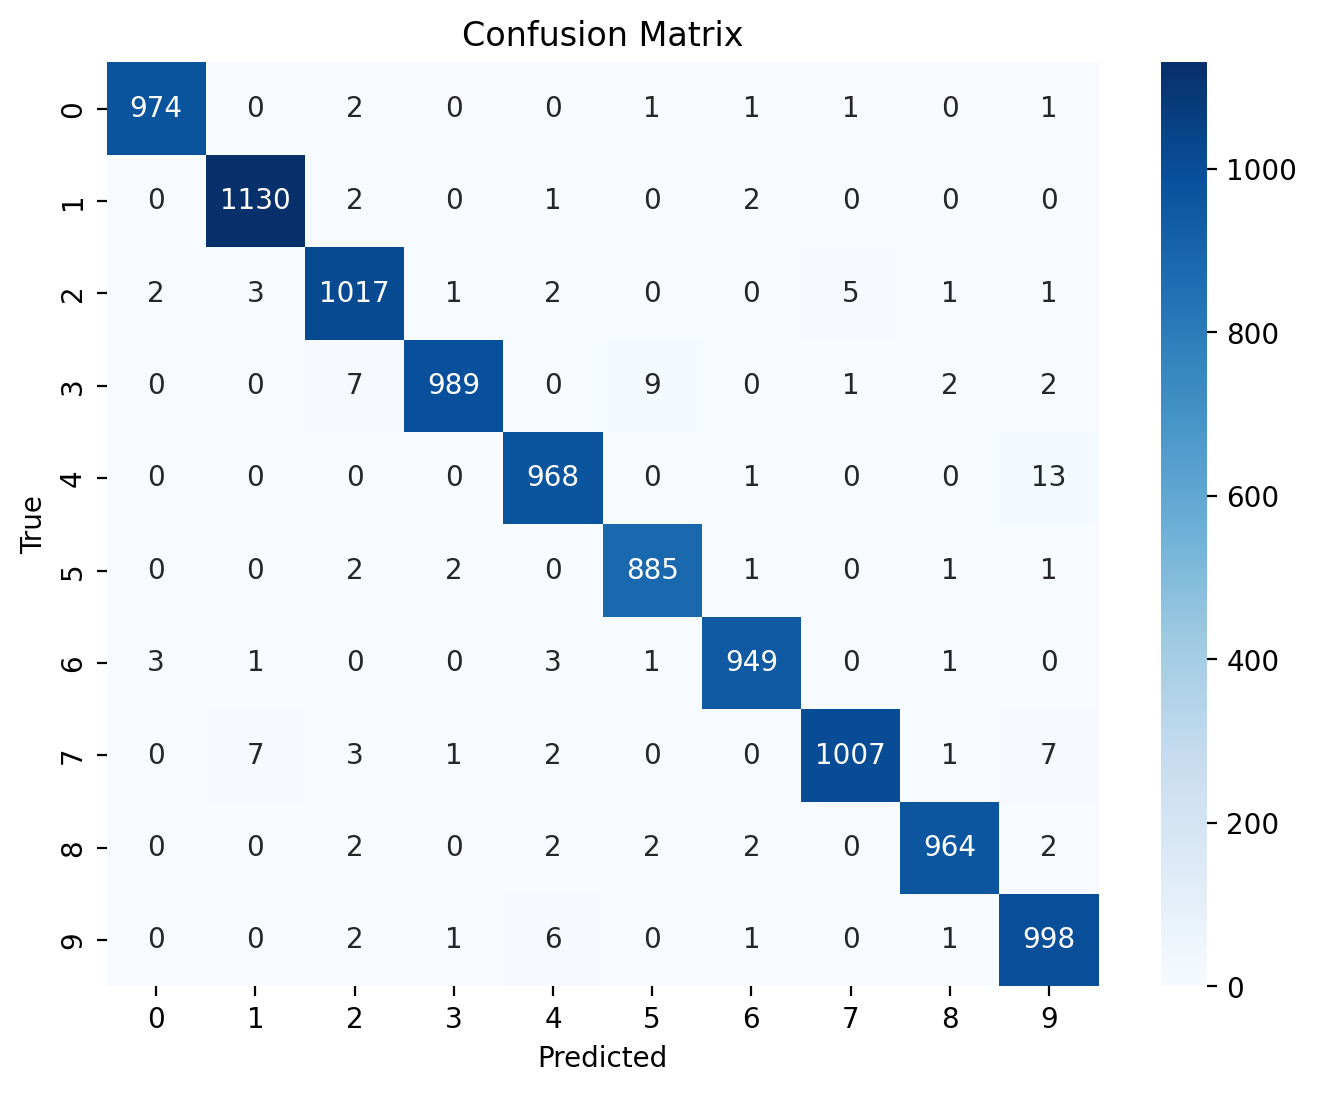

Accuracy       : 98.81%
F1-score (macro): 0.9881
Number of Parameters: 898,890
Inference Time on Test Set: 26.0722 seconds


In [21]:
test_trained = torchvision.datasets.MNIST(root='./data', train=False, transform=train_transform)
test_loader_trained = DataLoader(test_trained, batch_size=64, shuffle=False)


acc_trained_mobilenet, f1_trained_mobilenet, params_trained_mobilenet, inference_time_trained_mobilenet = evaluate_model(model_mobilenet_train, test_loader_trained, device=device)

### Fine-tuning the pretrained Efficient_net model on the MNIST dataset

In [20]:
model_efficientnet_train = models.efficientnet_b0(weights='IMAGENET1K_V1')
model_efficientnet_train.classifier[1] = nn.Linear(1280, 10)  # 10 output classes (digits 0–9)
model_efficientnet_train = model_efficientnet_train.to(device)


for param in model_efficientnet_train.parameters():
    param.requires_grad = False

for param in model_efficientnet_train.features[-2:].parameters():
    param.requires_grad = True  # last two blocks

for param in model_efficientnet_train.classifier.parameters():
    param.requires_grad = True  # classifier head

model_efficientnet_train = model_efficientnet_train.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_efficientnet_train.classifier.parameters(), lr=1e-3)


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=train_transform)

train_efficientnet_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


num_epochs = 5


for epoch in range(num_epochs):
    model_efficientnet_train.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_efficientnet_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model_efficientnet_train(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Loss: {running_loss/len(train_mobilenet_loader):.4f} | "
          f"Train Acc: {100*correct/total:.2f}%")

Epoch [1/5] Loss: 0.4850 | Train Acc: 87.38%
Epoch [2/5] Loss: 0.2694 | Train Acc: 92.04%
Epoch [3/5] Loss: 0.2398 | Train Acc: 92.61%
Epoch [4/5] Loss: 0.2222 | Train Acc: 92.99%
Epoch [5/5] Loss: 0.2122 | Train Acc: 93.34%


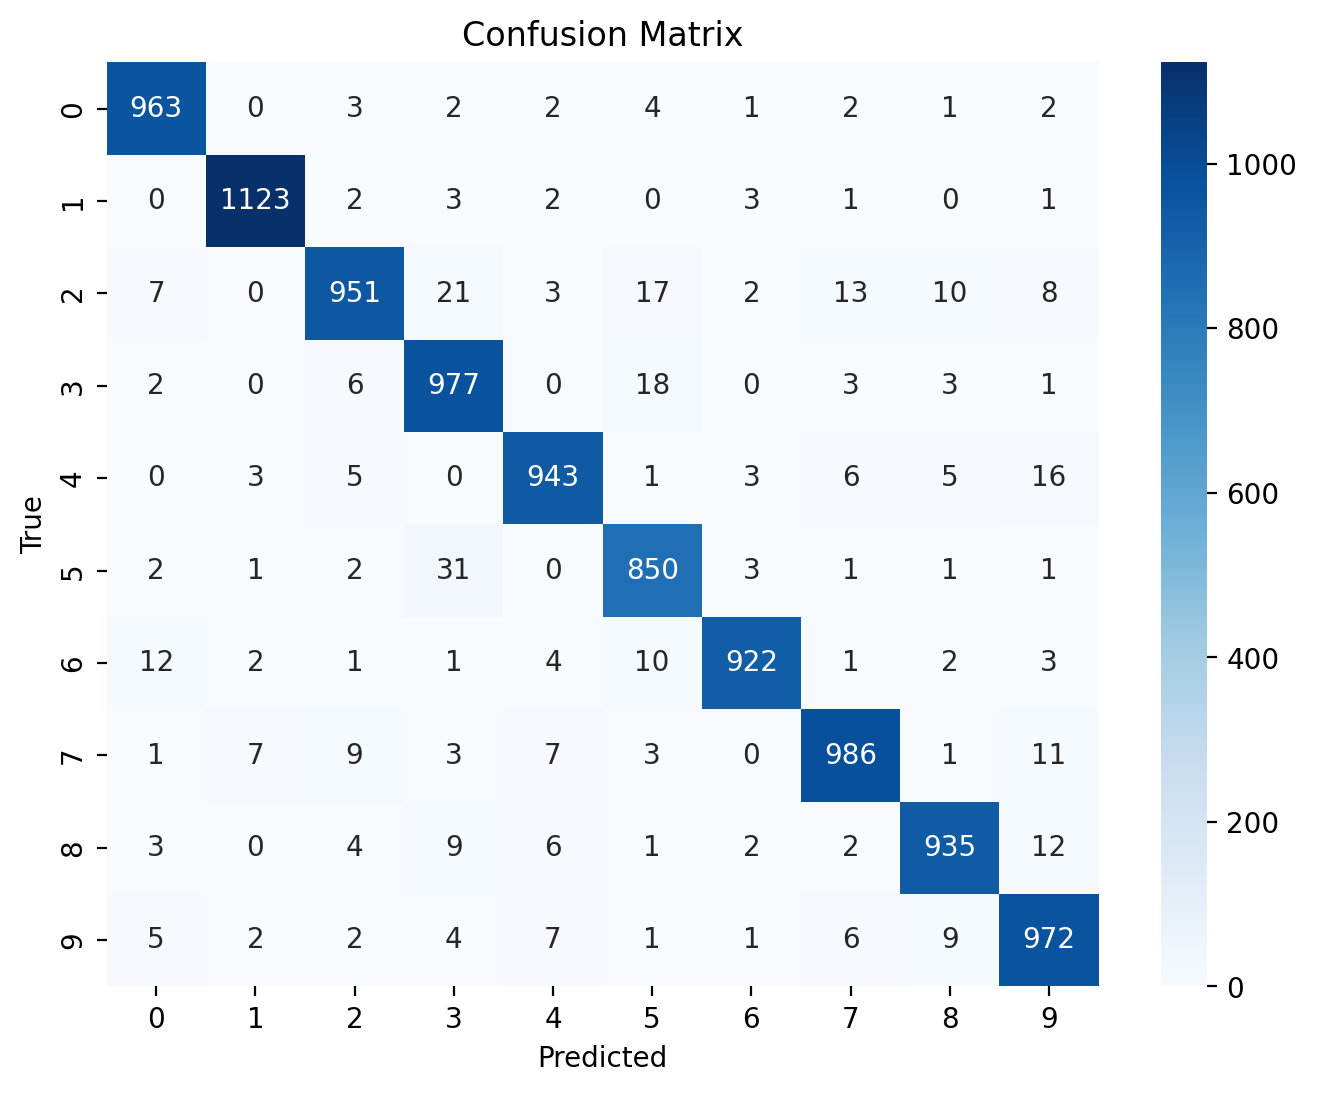

Accuracy       : 96.22%
F1-score (macro): 0.9618
Number of Parameters: 1,142,202
Inference Time on Test Set: 29.3739 seconds


In [22]:
acc_trained_efficientnet, f1_trained_efficientnet, params_trained_efficientnet, inference_time_trained_efficientnet = evaluate_model(model_efficientnet_train, test_loader_trained, device=device)

In [26]:
import pandas as pd

# Create a comparison dictionary
data = {
    "Model": [
        "CNN (Custom)",
        "MobileNetV2 (Fine-tuned)",
        "EfficientNetB0 (Fine-tuned)"
    ],
    "Accuracy": [
        cnn_acc,
        acc_trained_mobilenet,
        acc_trained_efficientnet
    ],
    "F1-Score": [
        cnn_f1,
        f1_trained_mobilenet,
        f1_trained_efficientnet
    ],
    "Parameters": [
        cnn_params,
        params_trained_mobilenet,
        params_trained_efficientnet
    ],
    "Inference Time (s)": [
        cnn_inference_time,
        inference_time_trained_mobilenet,
        inference_time_trained_efficientnet
    ]
}

# Convert to DataFrame
df_comparison_trained = pd.DataFrame(data)

# Optional: Sort by accuracy (descending)
df_comparison_trained = df_comparison_trained.sort_values(by="Accuracy", ascending=False).reset_index(drop=True)


df_comparison_trained



,Model,Accuracy,F1-Score,Parameters,Inference Time (s)
0,MobileNetV2 (Fine-tuned),0.9881,0.988102,898890,26.072223
1,CNN (Custom),0.9858,0.985702,804554,2.471390
2,EfficientNetB0 (Fine-tuned),0.9622,0.961836,1142202,29.373948


After fine-tuning, MobileNetV2 achieved the highest accuracy (98.81%) and F1-score (0.9881), slightly outperforming the custom CNN (98.58%) and EfficientNetB0 (96.22%). Fine-tuning allowed the pretrained models to adapt their learned ImageNet features to MNIST’s digit patterns, resulting in a substantial performance gain compared to their earlier, non-fine-tuned versions.

However, despite their improved accuracy, the fine-tuned models still required longer inference times (≈26–29 s) due to their deeper architectures and higher parameter counts. In contrast, the custom CNN, though slightly less accurate, remained significantly faster and more efficient.

Fine-tuning pretrained models on the MNIST dataset greatly improved their performance, demonstrating the effectiveness of transfer learning. MobileNetV2 (fine-tuned) achieved the best balance between accuracy and model size, while the custom CNN remained the most computationally efficient. This shows that pretrained architectures can outperform traditional CNNs when properly adapted, but at the cost of higher inference time.


